# PIPLINE FOR STOCKS

In [41]:
%pip install vnstock
%pip install scipy
%pip install mplfinance

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [42]:
import pandas as pd

pd.set_option('display.width', 2000)        
pd.set_option('display.max_columns', 20) 

In [43]:
from vnstock import *
from vnstock import Vnstock
import pandas as pd
from datetime import datetime
import mplfinance as mpf
from matplotlib.dates import DateFormatter
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from typing import Tuple
from numpy.random import multivariate_normal
import matplotlib.dates as mdates
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
import re

In [44]:
def crawl_data_portfolio(list_stock, start_date, end_date, interval='1H'):
    
    all_data = []

    for symbol in list_stock:
        try:
            stock = Vnstock().stock(symbol=symbol, source='TCBS')
            df = stock.quote.history(start=start_date, end=end_date, interval=interval)
            df['symbol'] = symbol
            all_data.append(df)
        except Exception as e:
            print(f"⚠️ Lỗi khi lấy dữ liệu cho {symbol}: {e}")
            continue

    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame()  

In [45]:
tickers = ['HPG','VCI','TCB','FPT']
holding_units = [1000, 5000, 2000, 3000]  
df_portfolio = crawl_data_portfolio(tickers, start_date='2022-06-16', end_date='2025-06-16', interval='1D')

2025-10-08 20:01:38 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.
2025-10-08 20:01:39 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.
2025-10-08 20:01:40 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.
2025-10-08 20:01:41 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.


In [46]:
df_pivot = df_portfolio.pivot_table(index='time', columns='symbol', values='close', aggfunc='last')
df_pivot = df_pivot.dropna()

In [47]:
returns = df_pivot.pct_change().dropna()
weights = np.array([0.25] * 4)  # Equal weights
port_returns = returns.dot(weights)
volatility = port_returns.std() * np.sqrt(252)  # Annualized
print(f"Portfolio Monthly Return: {port_returns.mean() * 30:.2%}")
print(f"Annual Volatility: {volatility:.2%}")

Portfolio Monthly Return: 2.88%
Annual Volatility: 27.63%


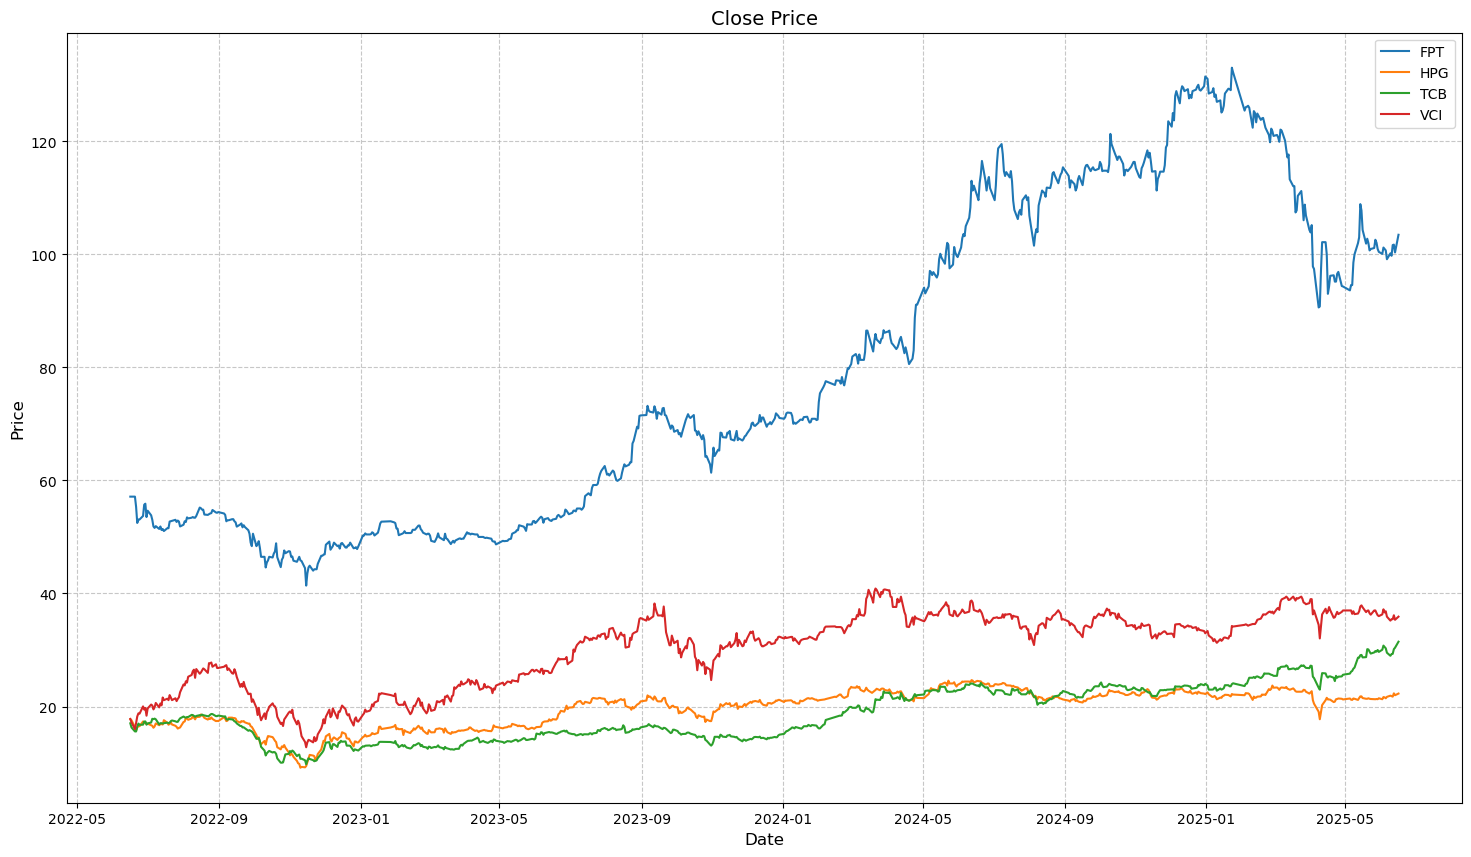

In [48]:
plt.figure(figsize=(18,10))
# Vẽ line chart cho cổ phiếu:
for col in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[col], label=col)

plt.title("Close Price", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [49]:
data = pd.DataFrame({'port_return': port_returns})
for lag in [1,2,3]:
    data[f'lag_{lag}'] = data['port_return'].shift(lag)
data['ma5'] = data['port_return'].rolling(5).mean()
data['vol5'] = data['port_return'].rolling(5).std()
data.dropna(inplace=True)
data['target'] = (data['port_return'].shift(-1) > 0).astype(int)
data.dropna(inplace=True)

X = data.drop(['port_return', 'target'], axis=1)
y = data['target']

In [50]:
tscv = TimeSeriesSplit(n_splits=3)
param_grid = {'n_estimators': [10, 50], 'max_depth': [None, 3, 5]}
model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='accuracy')
grid_search.fit(X, y)
best_model = grid_search.best_estimator_
print(f"best_model:  {grid_search.best_estimator_}")

best_model:  RandomForestClassifier(max_depth=3, n_estimators=10, random_state=42)


In [51]:
# Feature importance
feature_import = best_model.feature_importances_
for feature, imp in zip(X.columns, feature_import):
    print(f"{feature}: {imp:.4f}")

lag_1: 0.2015
lag_2: 0.2140
lag_3: 0.0526
ma5: 0.2264
vol5: 0.3055


In [52]:
# Precision-Recall
probas = best_model.predict_proba(X)[:, 1]
precision, recall, thresholds = precision_recall_curve(y, probas)

In [53]:
def compute_portfolio_var(df_portfolio, list_stock, holding_units, confidence_level=0.95, T=1):
 

    # 1. Pivot dữ liệu thành dạng mỗi cột là một cổ phiếu
    df_pivot = df_portfolio.pivot_table(index='time', columns='symbol', values='close', aggfunc='last')
    df_pivot = df_pivot[list_stock].dropna()

    # 2. Tính log-returns
    log_returns = np.log(df_pivot / df_pivot.shift(1)).dropna()

    # 3. Tính ma trận hiệp phương sai
    cov_matrix = log_returns.cov()

    # 4. Tính tỷ trọng từng mã trong danh mục
    prices_latest = df_pivot.iloc[-1]
    values = prices_latest.values * holding_units
    portfolio_value = np.sum(values)
    weights = values / portfolio_value

    # 5. Tính phương sai và độ lệch chuẩn danh mục
    port_variance = np.dot(weights, np.dot(cov_matrix.values * T, weights.T))
    port_std_dev = np.sqrt(port_variance)

    # 6. Z-score theo mức độ tin cậy
    z_score = norm.ppf(confidence_level)

    # 7. Tính VaR (theo giá trị danh mục)
    var_pct = z_score * port_std_dev
    var_amount = portfolio_value * var_pct

    # 8. Mô phỏng giá trị danh mục trong T ngày tới (dải rủi ro)
    forecast_dates = pd.date_range(start=df_pivot.index[-1] + pd.Timedelta(days=0), periods=T)
    expected_return = log_returns.mean().dot(weights) * T
    future_mean = np.exp(expected_return)
    future_std_low = np.exp(expected_return - z_score * port_std_dev)
    future_std_high = np.exp(expected_return + z_score * port_std_dev)

    portfolio_min_value = [portfolio_value * (future_std_low ** i) for i in range(0, T)]
    portfolio_max_value = [portfolio_value * (future_std_high ** i) for i in range(0, T)]

    df_forecast = pd.DataFrame({
        'time': forecast_dates,
        'portfolio_min_value': portfolio_min_value,
        'portfolio_max_value': portfolio_max_value
    })

    return {
        'portfolio_value': portfolio_value,
        'VaR_pct': var_pct,
        'VaR_amount': var_amount,
        'confidence_level': confidence_level,
        'holding_units': holding_units,
        'weights': weights,
        'cov_matrix': cov_matrix,
        'log_returns': log_returns,
        'forecast_df': df_forecast
    }


In [54]:
def build_portfolio_value_series(df_portfolio, list_stock, holding_units):
    """
    Tạo chuỗi giá trị danh mục theo ngày.

    Args:
        df_portfolio (DataFrame): Dữ liệu có cột 'time', 'symbol', 'close'.
        list_stock (list): Danh sách mã cổ phiếu.
        holding_units (list): Số lượng nắm giữ tương ứng.

    Returns:
        DataFrame: gồm 'time' và 'portfolio_value'
    """
    df_pivot = df_portfolio.pivot_table(index='time', columns='symbol', values='close', aggfunc='last')
    df_pivot = df_pivot[list_stock].dropna()
    weights = np.array(holding_units)
    df_pivot['portfolio_value'] = (df_pivot.values * weights).sum(axis=1)
    df_pivot = df_pivot[['portfolio_value']]
    df_pivot.reset_index(inplace=True)
    return df_pivot


def forecast_portfolio_value_with_var(df_value: pd.DataFrame,
                                      list_stock: list,
                                      holding_units: list,
                                      confidence_level: float = 0.95,
                                      T: int = 5,
                                      days_back: int = 60,
                                      figsize: tuple = (12, 6),
                                      datetime_format: str = '%Y-%m-%d'):
    """
    Vẽ biểu đồ khoảng giá trị danh mục dự báo ±VaR trong T ngày tới.

    Args:
        df_value: DataFrame gồm cột 'time', 'symbol', 'close'
        list_stock: Danh sách cổ phiếu trong danh mục
        holding_units: Số lượng nắm giữ tương ứng với từng cổ phiếu
    """
    if len(list_stock) != len(holding_units):
        raise ValueError(f"Số lượng mã cổ phiếu ({len(list_stock)}) và số lượng nắm giữ ({len(holding_units)}) không khớp.")

    df_port_value = build_portfolio_value_series(df_value, list_stock, holding_units)
    df = df_port_value.copy()
    df.set_index('time', inplace=True)
    df = df.sort_index()

    # Tính log-return chuỗi danh mục
    df['log_return'] = np.log(df['portfolio_value'] / df['portfolio_value'].shift(1))
    returns = df['log_return'].dropna()
    mu = returns.mean() * T
    sigma = returns.std(ddof=1) * np.sqrt(T)
    z = norm.ppf(confidence_level)

    # Giá trị hiện tại
    S0 = df['portfolio_value'].iloc[-1]

    # Dự phóng khoảng giá trị
    future_mean = np.exp(mu)
    future_std_low = np.exp(mu - z * sigma)
    future_std_high = np.exp(mu + z * sigma)

    forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=0), periods=T)

    future_central = [S0 * future_mean**i for i in range(0, T)]
    future_lower = [S0 * future_std_low**i for i in range(0, T)]
    future_upper = [S0 * future_std_high**i for i in range(0, T)]

    # Dữ liệu quá khứ
    df_plot = df.iloc[-days_back:]

    # Vẽ biểu đồ
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(df_plot.index, df_plot['portfolio_value'], color='black', label='Portfolio Value (Past)')
    ax.plot(forecast_dates, future_central, color='blue', linestyle='--', label='Expected Future Value')
    ax.fill_between(forecast_dates, future_lower, future_upper,
                    color='orange', alpha=0.3,
                    label=f'Forecast Range ±VaR ({int(confidence_level*100)}% T={T}d)')

    ax.set_title(f"Forecast Portfolio Value with VaR ({int(confidence_level*100)}%, T={T}d)")
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value')
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter(datetime_format))
    fig.autofmt_xdate()
    ax.legend()
    plt.tight_layout()
    plt.show()



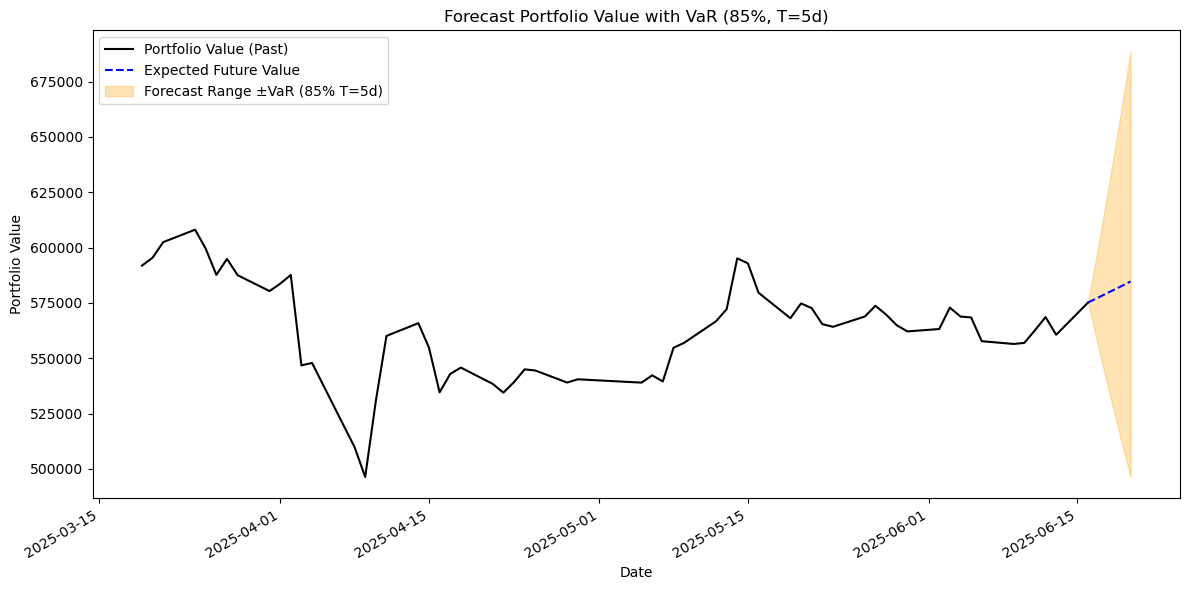

In [55]:
# 2. Vẽ khoảng dự báo với VaR
forecast_portfolio_value_with_var(df_portfolio,list_stock = tickers, holding_units = holding_units, confidence_level=0.85, T=5)

In [56]:
def monte_carlo_portfolio_var(
    df_portfolio, list_stock, holding_units,
    confidence_level=0.95, T=1, n_simulations=10000
):
    """
    Tính Monte Carlo VaR cho danh mục cổ phiếu.

    Args:
        df_portfolio (pd.DataFrame): Dữ liệu gồm cột 'symbol', 'time', 'close'.
        list_stock (list): Danh sách mã cổ phiếu.
        holding_units (list): Số lượng cổ phiếu tương ứng.
        confidence_level (float): Mức độ tin cậy.
        T (int): Kỳ hạn tính VaR (ngày).
        n_simulations (int): Số lần mô phỏng.

    Returns:
        dict: Thông tin VaR và mô phỏng.
    """

    # 1. Chuẩn bị dữ liệu
    df_pivot = df_portfolio.pivot(index='time', columns='symbol', values='close')
    df_pivot = df_pivot[list_stock].dropna()

    log_returns = np.log(df_pivot / df_pivot.shift(1)).dropna()
    mu = log_returns.mean().values  # Kỳ vọng lợi suất
    cov = log_returns.cov().values  # Ma trận hiệp phương sai

    # 2. Mô phỏng log-return tương lai (giả sử phân phối chuẩn đa biến)
    mean_T = mu * T
    cov_T = cov * T  # scale theo số ngày
    sim_returns = multivariate_normal(mean_T, cov_T, size=n_simulations)  # shape: (n_sim, n_assets)

    # 3. Tính giá giả định trong tương lai
    last_prices = df_pivot.iloc[-1].values
    future_prices = np.exp(sim_returns) * last_prices  # shape: (n_sim, n_assets)

    # 4. Tính giá trị danh mục mỗi lần mô phỏng
    sim_portfolio_values = future_prices.dot(np.array(holding_units))
    current_value = last_prices.dot(np.array(holding_units))
    profit_losses = sim_portfolio_values - current_value

    # 5. Tính VaR
    var_amount = -np.percentile(profit_losses, (1 - confidence_level) * 100)

    return {
        'VaR_amount': var_amount,
        'initial_value': current_value,
        'confidence_level': confidence_level,
        'T_days': T,
        'sim_portfolio_values': sim_portfolio_values,
        'profit_losses': profit_losses,
    }


In [57]:
def forecast_portfolio_range_with_var_monte_carlo(df_portfolio: pd.DataFrame,
                                                  list_stock: list,
                                                  holding_units: list,
                                                  confidence_level: float = 0.95,
                                                  T: int = 5,
                                                  days_back: int = 60,
                                                  figsize: tuple = (12, 6),
                                                  n_simulations: int = 10000,
                                                  datetime_format: str = '%Y-%m-%d'):
    """
    Dự báo khoảng giá trị portfolio sử dụng mô phỏng Monte Carlo VaR.

    Args:
        df_portfolio: DataFrame có cột 'time', 'symbol', 'close'.
        list_stock: Danh sách mã cổ phiếu trong portfolio.
        holding_units: Số lượng cổ phiếu nắm giữ tương ứng.
    """
    # Pivot để có dạng time-series
    df_pivot = df_portfolio.pivot(index='time', columns='symbol', values='close')
    df_pivot = df_pivot[list_stock].dropna()
    df_pivot.index = pd.to_datetime(df_pivot.index)
    log_returns = np.log(df_pivot / df_pivot.shift(1)).dropna()

    mu = log_returns.mean().values
    cov = log_returns.cov().values

    mean_T = mu * T
    cov_T = cov * T
    sim_returns = multivariate_normal(mean_T, cov_T, size=n_simulations)

    last_prices = df_pivot.iloc[-1].values
    future_prices = np.exp(sim_returns) * last_prices
    sim_portfolio_values = future_prices.dot(np.array(holding_units))
    current_value = last_prices.dot(np.array(holding_units))

    # Tính phân phối log-return
    portfolio_log_returns = np.log(sim_portfolio_values / current_value)

    mu_portfolio = portfolio_log_returns.mean()
    sigma_portfolio = portfolio_log_returns.std()

    forecast_dates = pd.date_range(start=df_pivot.index[-1] + pd.Timedelta(days=0), periods=T)

    # Tính khoảng dự báo
    expected_returns = mu_portfolio * np.arange(0, T)
    std_returns = sigma_portfolio * np.sqrt(np.arange(0, T))

    central = current_value * np.exp(expected_returns)
    lower_bound = current_value * np.exp(expected_returns - norm.ppf(confidence_level) * std_returns)
    upper_bound = current_value * np.exp(expected_returns + norm.ppf(confidence_level) * std_returns)

    # Dữ liệu quá khứ
    portfolio_series = (df_pivot @ np.array(holding_units)).rename('portfolio_value')
    df_plot = portfolio_series.iloc[-days_back:]

    # Vẽ biểu đồ
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(df_plot.index, df_plot.values, color='black', label='Portfolio Value (Past)')
    ax.plot(forecast_dates, central, color='blue', linestyle='--', label='Expected Future Value')
    ax.fill_between(forecast_dates, lower_bound, upper_bound,
                    color='green', alpha=0.3,
                    label=f'Monte Carlo VaR ± ({int(confidence_level*100)}%, T={T}d)')

    ax.set_title(f"Forecast Portfolio Value (Monte Carlo VaR {int(confidence_level*100)}%, T={T}d)")
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value')
    ax.xaxis.set_major_formatter(mdates.DateFormatter(datetime_format))
    fig.autofmt_xdate()
    ax.legend()
    plt.tight_layout()
    plt.show()

    # In kết quả
    var_amount = -np.percentile(sim_portfolio_values - current_value, (1 - confidence_level) * 100)
    print(f"VaR {int(confidence_level*100)}% over {T} days: {var_amount:,.2f} VND")



In [58]:
def forecast_portfolio_range_with_var_monte_carlo(df_portfolio: pd.DataFrame,
                                                  list_stock: list,
                                                  holding_units: list,
                                                  confidence_level: float = 0.95,
                                                  T: int = 5,
                                                  days_back: int = 60,
                                                  figsize: tuple = (12, 6),
                                                  n_simulations: int = 10000,
                                                  datetime_format: str = '%Y-%m-%d'):
    """
    Dự báo khoảng giá trị portfolio sử dụng mô phỏng Monte Carlo VaR.

    Args:
        df_portfolio: DataFrame có cột 'time', 'symbol', 'close'.
        list_stock: Danh sách mã cổ phiếu trong portfolio.
        holding_units: Số lượng cổ phiếu nắm giữ tương ứng.
    """
    # Pivot để có dạng time-series (fix lỗi duplicate index)
    df_pivot = df_portfolio.pivot_table(index='time', columns='symbol', values='close', aggfunc='last')
    df_pivot = df_pivot[list_stock].dropna()
    df_pivot.index = pd.to_datetime(df_pivot.index)
    log_returns = np.log(df_pivot / df_pivot.shift(1)).dropna()

    # Tính toán tham số mô phỏng
    mu = log_returns.mean().values
    cov = log_returns.cov().values
    mean_T = mu * T
    cov_T = cov * T
    sim_returns = multivariate_normal(mean_T, cov_T, size=n_simulations)

    # Mô phỏng giá trong T ngày tới
    last_prices = df_pivot.iloc[-1].values
    future_prices = np.exp(sim_returns) * last_prices
    sim_portfolio_values = future_prices.dot(np.array(holding_units))
    current_value = last_prices.dot(np.array(holding_units))

    # Tính log-return danh mục
    portfolio_log_returns = np.log(sim_portfolio_values / current_value)
    mu_portfolio = portfolio_log_returns.mean()
    sigma_portfolio = portfolio_log_returns.std()

    forecast_dates = pd.date_range(start=df_pivot.index[-1] + pd.Timedelta(days=0), periods=T)

    # Tính khoảng dự báo (giá trị tương lai)
    expected_returns = mu_portfolio * np.arange(T)
    std_returns = sigma_portfolio * np.sqrt(np.arange(T))
    central = current_value * np.exp(expected_returns)
    lower_bound = current_value * np.exp(expected_returns - norm.ppf(confidence_level) * std_returns)
    upper_bound = current_value * np.exp(expected_returns + norm.ppf(confidence_level) * std_returns)

    # Dữ liệu quá khứ
    portfolio_series = (df_pivot @ np.array(holding_units)).rename('portfolio_value')
    df_plot = portfolio_series.iloc[-days_back:]

    # Vẽ biểu đồ
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(df_plot.index, df_plot.values, color='black', label='Portfolio Value (Past)')
    ax.plot(forecast_dates, central, color='blue', linestyle='--', label='Expected Future Value')
    ax.fill_between(forecast_dates, lower_bound, upper_bound,
                    color='green', alpha=0.3,
                    label=f'Monte Carlo VaR ± ({int(confidence_level*100)}%, T={T}d)')

    ax.set_title(f"Forecast Portfolio Value (Monte Carlo VaR {int(confidence_level*100)}%, T={T}d)")
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value')
    ax.xaxis.set_major_formatter(mdates.DateFormatter(datetime_format))
    fig.autofmt_xdate()
    ax.legend()
    plt.tight_layout()
    plt.show()

    # In kết quả VaR
    var_amount = -np.percentile(sim_portfolio_values - current_value, (1 - confidence_level) * 100)
    var_pct = var_amount / current_value
    print(f"✅ VaR {int(confidence_level*100)}% over {T} days: {var_amount:,.2f} VND ({-var_pct:.2%})")


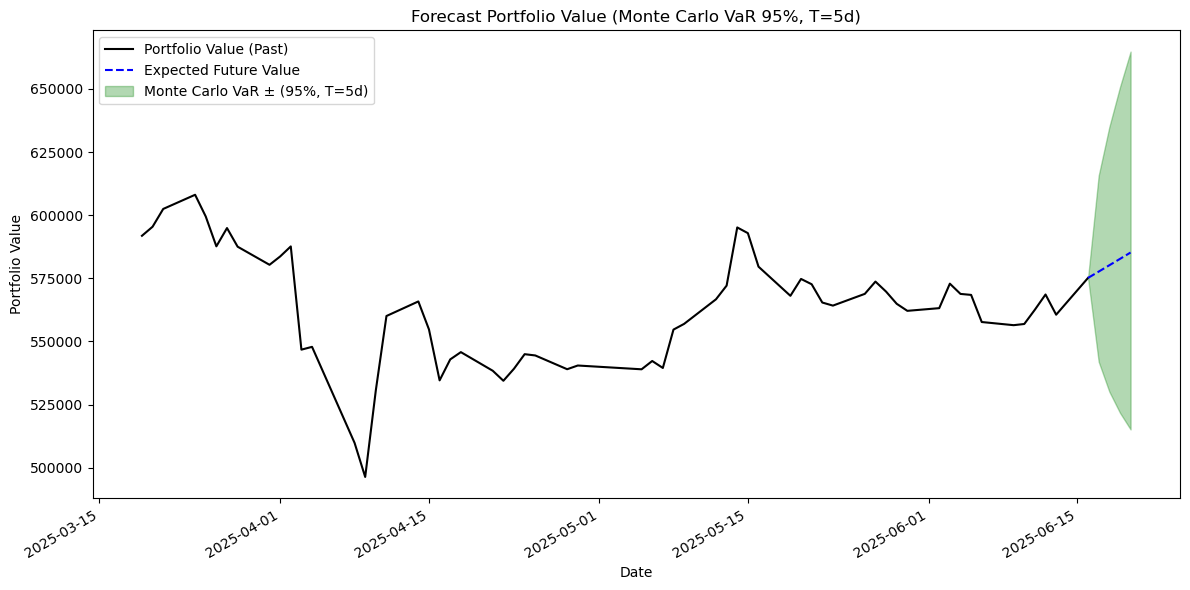

✅ VaR 95% over 5 days: 32,824.31 VND (-5.71%)


In [59]:
forecast_portfolio_range_with_var_monte_carlo(
    df_portfolio=df_portfolio,
    list_stock=tickers,
    holding_units=holding_units,
    confidence_level=0.95,
    T=5
)

In [60]:
def forecast_portfolio_value_with_cvar(df_value: pd.DataFrame,
                                       list_stock: list,
                                       holding_units: list,
                                       confidence_level: float = 0.95,
                                       T: int = 5,
                                       days_back: int = 60,
                                       figsize: tuple = (12, 6),
                                       datetime_format: str = '%Y-%m-%d'):
    """
    Vẽ khoảng giá trị danh mục dự báo với CVaR (Expected Shortfall) trong T ngày tới.

    Args:
        df_value: DataFrame gồm cột 'time', 'symbol', 'close'
        list_stock: Danh sách mã cổ phiếu
        holding_units: Số lượng nắm giữ tương ứng
        confidence_level: Mức tin cậy (thường 0.95 hoặc 0.99)
        T: số ngày forecast
    """
    def build_portfolio_value_series(df_portfolio, list_stock, holding_units):
        df_pivot = df_portfolio.pivot_table(index='time', columns='symbol', values='close', aggfunc='last')
        df_pivot = df_pivot[list_stock].dropna()
        weights = np.array(holding_units)
        df_pivot['portfolio_value'] = (df_pivot.values * weights).sum(axis=1)
        df_pivot = df_pivot[['portfolio_value']]
        df_pivot.reset_index(inplace=True)
        return df_pivot

    if len(list_stock) != len(holding_units):
        raise ValueError("list_stock và holding_units phải có cùng độ dài.")

    df_port_value = build_portfolio_value_series(df_value, list_stock, holding_units)
    df = df_port_value.copy()
    df.set_index('time', inplace=True)
    df = df.sort_index()

    # Tính log-return
    df['log_return'] = np.log(df['portfolio_value'] / df['portfolio_value'].shift(1))
    returns = df['log_return'].dropna()

    # Ước lượng tham số
    mu = returns.mean() * T
    sigma = returns.std(ddof=1) * np.sqrt(T)
    z = norm.ppf(confidence_level)

    # Tính CVaR theo phân phối chuẩn
    alpha = 1 - confidence_level
    cvar_pct = -(mu - sigma * norm.pdf(z) / alpha)

    # Giá trị danh mục hiện tại
    S0 = df['portfolio_value'].iloc[-1]
    cvar_amount = cvar_pct * S0

    # Forecast theo hình mũ
    forecast_dates = pd.date_range(start=df.index[-1]  , periods=T+1)
    future_central = [S0 * np.exp(mu * t / T) for t in range(0, T+1)]
    future_lower = [S0 * np.exp((mu - sigma * norm.pdf(z) / alpha) * t / T) for t in range(0, T+1)]
    future_upper = [S0 * np.exp((mu + z * sigma) * t / T) for t in range(0, T+1)]

    # Biểu đồ quá khứ
    df_plot = df.iloc[-days_back:]

    # Vẽ biểu đồ
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(df_plot.index, df_plot['portfolio_value'], color='black', label='Portfolio Value (Past)')
    ax.plot(forecast_dates, future_central, color='blue', linestyle='--', label='Expected Value')
    ax.fill_between(forecast_dates, future_lower, future_upper,
                    color='red', alpha=0.3,
                    label=f'Forecast ±CVaR ({int(confidence_level*100)}%, T={T}d)')

    ax.set_title(f"Forecast Portfolio Value with CVaR ({int(confidence_level*100)}%, T={T}d)")
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value')
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter(datetime_format))
    fig.autofmt_xdate()
    ax.legend()
    plt.tight_layout()
    plt.show()

    print(f"✅ CVaR {int(confidence_level*100)}% over {T} days: {-cvar_amount:,.2f} VND ({-cvar_pct:.2%})")


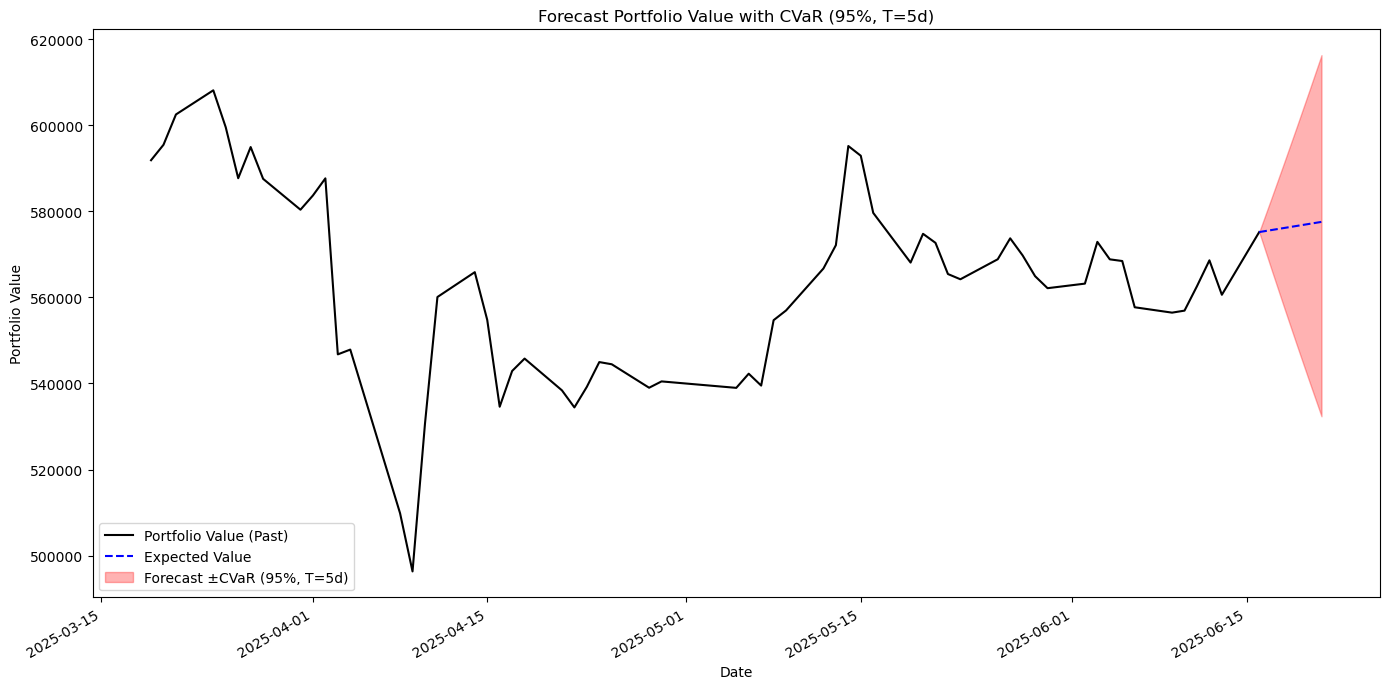

✅ CVaR 95% over 5 days: -44,464.54 VND (-7.73%)


In [61]:
forecast_portfolio_value_with_cvar(df_portfolio, list_stock=tickers, holding_units=holding_units,
                                    confidence_level=0.95, T=5, days_back=60, figsize=(14, 7))

In [62]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_portfolio['SMA20'] = df_portfolio['close'].rolling(window=20).mean()
df_portfolio['SMA50'] = df_portfolio['close'].rolling(window=50).mean()

In [64]:
#Tính RSI
def calculate_rsi(df_portfolio, periods=14):
    delta = df_portfolio['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=periods).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df_portfolio['RSI'] = calculate_rsi(df_portfolio).fillna(0)

print(df_portfolio['RSI'])

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
          ...    
3951    39.168279
3952    54.296161
3953    53.617811
3954    46.705588
3955    53.221083
Name: RSI, Length: 3956, dtype: float64


In [65]:
# Tạo biến mục tiêu cho bài toán phân loại (tăng = 1, giảm = 0):
df_portfolio['Price_Up'] = (df_portfolio['close'].shift(-1) > df_portfolio['close']).astype(int)

# Đặc trưng đầu vào:
features = ['open', 'high', 'low', 'volume', 'SMA20', 'SMA50', 'RSI']
X = df_portfolio[features].fillna(0)
y_regression = df_portfolio['close']  # Biến mục tiêu cho hồi quy
y_classification = df_portfolio['Price_Up']  # Biến mục tiêu cho phân loại

# Chia dữ liệu train/test (80/20):
X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf = train_test_split(
    X, y_regression, y_classification, test_size=0.2, shuffle=False
)

# Chuẩn hóa dữ liệu:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [66]:
# Linear Regression:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_reg)
lr_pred = lr_model.predict(X_test_scaled)
lr_rmse = np.sqrt(mean_squared_error(y_test_reg, lr_pred))
lr_mae = mean_absolute_error(y_test_reg, lr_pred)
print(f'Linear Regression RMSE: {lr_rmse:.2f}')
print(f'Linear Regression MAE: {lr_mae:.2f}', "\n")

# Decision Tree Regressor:
dt_reg_model = DecisionTreeRegressor(random_state=42)
dt_reg_model.fit(X_train_scaled, y_train_reg)
dt_reg_pred = dt_reg_model.predict(X_test_scaled)
dt_reg_rmse = np.sqrt(mean_squared_error(y_test_reg, dt_reg_pred))
dt_reg_mae = mean_absolute_error(y_test_reg, dt_reg_pred)
print(f'Decision Tree Regressor RMSE: {dt_reg_rmse:.2f}')
print(f'Decision Tree Regressor MAE: {dt_reg_mae:.2f}')

# Logistic Regression:
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train_scaled, y_train_clf)
log_reg_pred = log_reg_model.predict(X_test_scaled)
log_reg_pred_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]
log_reg_cm = confusion_matrix(y_test_clf, log_reg_pred)
log_reg_auc = roc_auc_score(y_test_clf, log_reg_pred_proba)
print(f'Logistic Regression Confusion Matrix:\n{log_reg_cm}', "\n")
print(f'Logistic Regression AUC: {log_reg_auc:.2f}', "\n")

# Decision Tree Classifier:
dt_clf_model = DecisionTreeClassifier(random_state=42)
dt_clf_model.fit(X_train_scaled, y_train_clf)
dt_clf_pred = dt_clf_model.predict(X_test_scaled)
dt_clf_pred_proba = dt_clf_model.predict_proba(X_test_scaled)[:, 1]
dt_clf_cm = confusion_matrix(y_test_clf, dt_clf_pred)
dt_clf_auc = roc_auc_score(y_test_clf, dt_clf_pred_proba)
print(f'Decision Tree Classifier Confusion Matrix:\n{dt_clf_cm}', "\n")
print(f"Decision Tree Classifier - AUC: {dt_clf_auc:.2f}")

Linear Regression RMSE: 0.71
Linear Regression MAE: 0.51 

Decision Tree Regressor RMSE: 49.06
Decision Tree Regressor MAE: 42.77
Logistic Regression Confusion Matrix:
[[390   2]
 [400   0]] 

Logistic Regression AUC: 0.50 

Decision Tree Classifier Confusion Matrix:
[[352  40]
 [343  57]] 

Decision Tree Classifier - AUC: 0.52


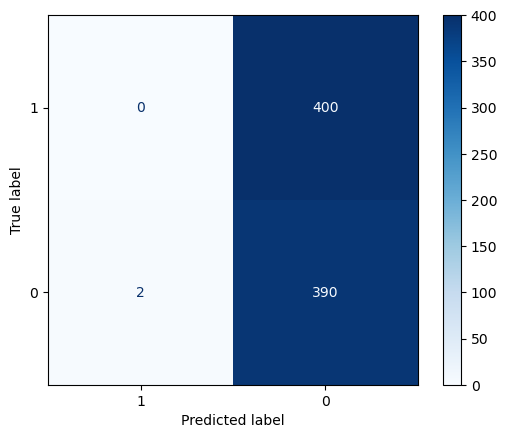

In [67]:
#Confusion matrix:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test_clf,
                                        log_reg_pred,
                                        labels = [1, 0],
                                        cmap = 'Blues' # colormap
                                       )

In [68]:
from sklearn.metrics import classification_report, accuracy_score

print(accuracy_score(y_test_clf, log_reg_pred))
print(classification_report(y_test_clf, log_reg_pred))

0.49242424242424243
              precision    recall  f1-score   support

           0       0.49      0.99      0.66       392
           1       0.00      0.00      0.00       400

    accuracy                           0.49       792
   macro avg       0.25      0.50      0.33       792
weighted avg       0.24      0.49      0.33       792



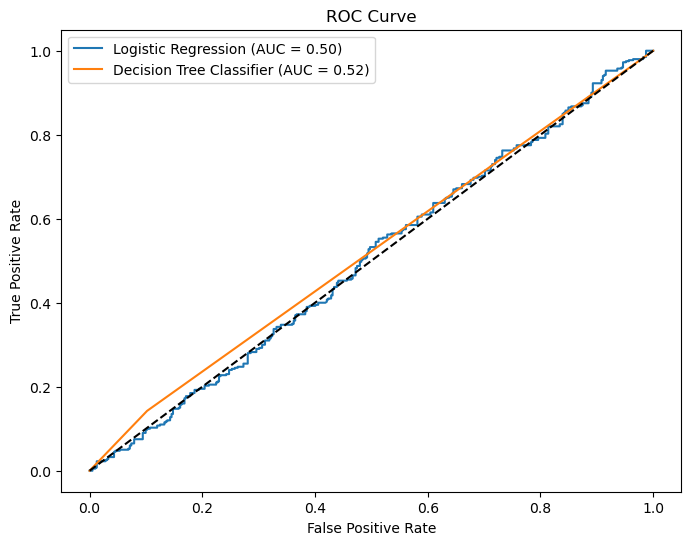

In [69]:
# Vẽ ROC Curve:
fpr_log, tpr_log, _ = roc_curve(y_test_clf, log_reg_pred_proba)
fpr_dt, tpr_dt, _ = roc_curve(y_test_clf, dt_clf_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {log_reg_auc:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree Classifier (AUC = {dt_clf_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()